# Computer Components MOO Problem

The objective of this exercise is to select computer components in order to build a computer satisfying the following objective:

$$Minimize\ [C_t(x),P_t(x)]; \ Maximize \ Q_t(x) \ subject \ to \ C_t(x) \leq 1700; P_t(x) \leq 2.5; r_i > 2.5$$

Where:

$$ \begin{array}{lcl} C_t(x) & =  & \sum c_i * x_i \\ 
Q_t(x) & = & \sum (w_i *r_i) * x_i \\
P_t(x) & = & \sum p_i * x_i \end{array} $$

Being:
- c_i: cost of a component, price
- w_i: weight associated to the component type, for calculation purposes, out of 1. See table bellow
- r_i: review index, quality
- p_i: weight of the component (kg), weight
- x_i: mask, 1 if the component is selected, 0 otherwise 

|Component | w_i   |
|----------|-------|
|  cpu     | 0.3   |
|  disk    | 0.2   |
|  board   | 0.1   |
|  ram     | 0.3   |
|  gpu     | 0.1   |
|  Total   |   1   |

## Dataset loading and filtering

In [1]:
import pandas as pd
import numpy as np

df = pd.read_csv('./delivery/pieces.csv')
print(df.head())
print(df.shape)

  type       price  quality    weight
0  cpu  172.158304      3.5  0.258227
1  cpu  120.820045      3.0  0.229969
2  cpu  131.290487      4.5  0.117316
3  cpu  110.145139      3.5  0.204912
4  cpu  123.840845      4.5  0.235732
(1000, 4)


One of the requirements of the problem is that:
$$ r_i > 2.5 $$
For this, elements not satisfying this condition will be removed from the dataset

In [2]:
df.drop(df[df.quality <= 2.5].index, inplace=True)
print(df.shape)
print(df.quality.mean())

(792, 4)
3.75126262626


Besides, each of the components quality will be multiplied by the weight related to that component importance.
The weight per component is displayed in the Table above.

In [3]:
components_weights = {'cpu':0.3, 'disk':0.2, 'board':0.1, 'ram':0.3, 'gpu': 0.1}

for component, weight in components_weights.items():
    index = df.loc[df['type'] == component].index
    df.loc[index[0]:index[len(index)-1],'quality'] *= weight
print(df.quality.mean())

0.749494949495


## Problem definition and solving

First the objective functions used in the problem are defined:

In [235]:
def obtain_selected_vars_no(selected_vars):
    ''' This function returns the total
        selected vars number '''
    return sum([1 if selected_vars[i] else 0 for i in range(len(selected_vars))])

In [236]:
def calculate_total_weight(selected_vars, input_df):
    ''' This function returns the total weight'''
    total_weight = 0
    components = input_df.type.unique()
    for idx,var in enumerate(selected_vars):
        weights_array = input_df.loc[df['type'] == components[idx]].weight.values.tolist()
        total_weight += sum([weights_array[i] if var[i] else 0 for i in range(len(var))])
    return total_weight

In [237]:
def calculate_total_cost(selected_vars, input_df):
    ''' This function returns the total cost '''
    total_cost = 0
    components = input_df.type.unique()
    for idx,var in enumerate(selected_vars):
        costs_array = input_df.loc[df['type'] == components[idx]].price.values.tolist()
        total_cost += sum([costs_array[i] if var[i] else 0 for i in range(len(var))])
    return total_cost

In [238]:
def calculate_total_quality(selected_vars, input_df):
    ''' This function returns the total quality '''
    total_quality = 0
    components = input_df.type.unique()
    for idx,var in enumerate(selected_vars):
        quality_array = input_df.loc[df['type'] == components[idx]].quality.values.tolist()
        total_quality += sum([quality_array[i] if var[i] else 0 for i in range(len(var))])
    return total_quality

Then, the function handling the problem's logic is defined:

In [239]:
from platypus import NSGAII, Problem, Constraint, Binary, nondominated
import functools
    
def computer_components_problem(x, arg1):
    ''' This function defines the logic of the 
        computer components selection problem '''
    selection = x[0]
    no_items_selected = obtain_selected_vars_no(selection)
    no_items_selected1 = obtain_selected_vars_no(x[1])
    no_items_selected2 = obtain_selected_vars_no(x[2])
    no_items_selected3 = obtain_selected_vars_no(x[3])
    no_items_selected4 = obtain_selected_vars_no(x[4])
    total_quality = calculate_total_quality(x, arg1)
    total_weight = calculate_total_weight(x, arg1)
    total_cost = calculate_total_cost(x, arg1)
    
    
    return [total_quality,total_weight,total_cost] , [ total_weight, no_items_selected,no_items_selected1,no_items_selected2, no_items_selected3, no_items_selected4, total_cost]

In this step the data is obtained:

In [240]:
# The data is added in the order that appears in the pandas dataframe
print(df.type.unique())
items = df.loc[df['type'] == 'cpu'].price.size
items1 = df.loc[df['type'] == 'disk'].price.size
items2 = df.loc[df['type'] == 'board'].price.size
items3 = df.loc[df['type'] == 'ram'].price.size
items4 = df.loc[df['type'] == 'gpu'].price.size

['cpu' 'disk' 'board' 'ram' 'gpu']


Now, the problem is defined:

In [241]:
problem = Problem(5, 3, 7)
problem.types[0] = Binary(items)
problem.types[1] = Binary(items1)
problem.types[2] = Binary(items2)
problem.types[3] = Binary(items3)
problem.types[4] = Binary(items4)

problem.directions[0] = Problem.MAXIMIZE
problem.directions[1:] = Problem.MINIMIZE
problem.constraints[0] = Constraint("<=", max_weight)
problem.constraints[1] = Constraint("==", no_items)
problem.constraints[2] = Constraint("==", no_items)
problem.constraints[3] = Constraint("==", no_items)
problem.constraints[4] = Constraint("==", no_items)
problem.constraints[5] = Constraint("==", no_items)
problem.constraints[6] = Constraint("<=", max_cost)
problem.function = functools.partial(computer_components_problem, arg1=df)

In [242]:
algorithm = NSGAII(problem)
algorithm.run(50000)

In [243]:
from platypus import unique as un
for solution in un(nondominated(algorithm.result)):
    print(obtain_selected_vars_no(solution.variables[0]),obtain_selected_vars_no(solution.variables[1]),obtain_selected_vars_no(solution.variables[2]),obtain_selected_vars_no(solution.variables[3]),obtain_selected_vars_no(solution.variables[4]))
    print(solution.objectives)

1 1 1 1 1
[3.8, 0.661983780397, 666.769966084]
1 1 1 1 1
[4.05, 0.653140459971, 923.718010627]
1 1 1 1 1
[3.9, 0.809113853791, 569.080198154]
1 1 1 1 1
[4.05, 0.959845713823, 622.166615719]
1 1 1 1 1
[4.1, 0.730798573912, 763.13148721]
1 1 1 1 1
[3.8, 0.640243962342, 711.537696712]
1 1 1 1 1
[4.05, 0.693499914474, 768.742309919]
1 1 1 1 1
[3.95, 0.957224373547, 602.753261176]
1 1 1 1 1
[4.0, 0.794434600414, 608.459610394]
1 1 1 1 1
[3.95, 0.738705432064, 619.378254125]
1 1 1 1 1
[4.0, 0.643956569968, 756.794489762]
1 1 1 1 1
[3.9, 0.681110455115, 646.557087317]
1 1 1 1 1
[3.85, 0.717488038853, 629.970620179]
1 1 1 1 1
[3.8, 0.695789708492, 607.177675077]
1 1 1 1 1
[3.85, 0.714344273733, 644.73263021]
1 1 1 1 1
[3.95, 0.708179167851, 729.362897678]
1 1 1 1 1
[3.9, 0.64730452702, 706.149378324]
1 1 1 1 1
[3.85, 0.736084091788, 599.964899582]
1 1 1 1 1
[3.8, 0.674049890436, 651.945405705]
1 1 1 1 1
[4.05, 0.724026178687, 658.757666365]
1 1 1 1 1
[3.95, 0.721404838411, 639.344311823]
1 1 1

The following volume is achieved by the results:

In [244]:
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import matplotlib as mpl

# Change default matplotlib figure size
mpl.rcParams['figure.figsize'] = (10,10)

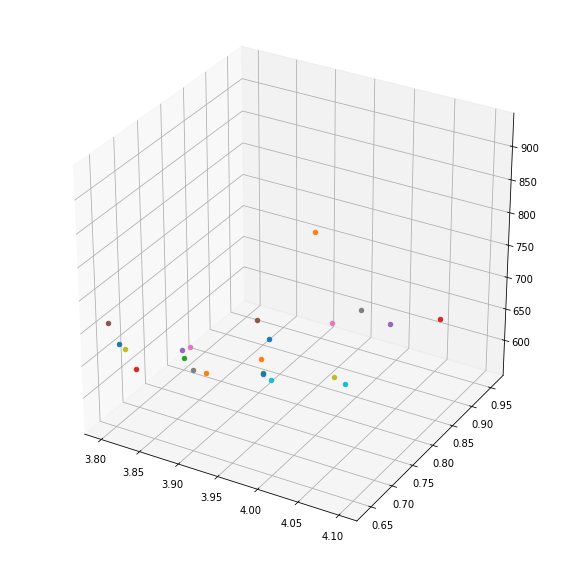

In [245]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for solution in un(nondominated(algorithm.result)):
    ax.scatter(*solution.objectives)
plt.show()
